In [5]:
# Import library
# http://ufldl.stanford.edu/wiki/index.php/Independent_Component_Analysis
# http://ufldl.stanford.edu/tutorial/unsupervised/ICA/
# http://ufldl.stanford.edu/tutorial/unsupervised/ExerciseRICA/
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [6]:
# Read the Data Set
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import rescale, resize
dataset = fetch_olivetti_faces(shuffle=True)
train_data  = dataset.data.reshape(400,64,64)

print('---- Before Centering -------')
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

print('---- After Centering and reshaping -------')
train_data  = (train_data-train_data.mean(1)[:,np.newaxis]).reshape(400,64,64)
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

---- Before Centering -------
(400, 64, 64)
0.0 1.0
0.54704237 0.17251529
---- After Centering and reshaping -------
(400, 64, 64)
-0.70247936 0.66270673
-1.8373248e-09 0.13796239


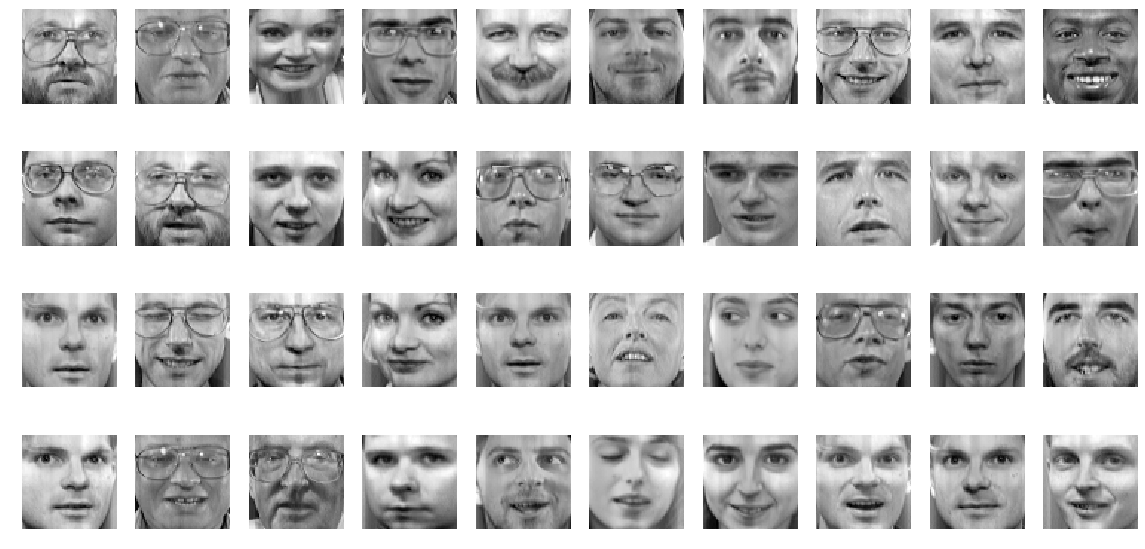

In [7]:
# show the image of the faces
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(train_data[i-1],cmap='gray')
plt.show()

In [8]:
# import all the layers
# ======= Activation Function  ==========
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)
# ======= Activation Function  ==========

class zca_whiten_layer():
    """ZCA Whiten operation layer.

    Parameters
    ----------
    self) : pass    def feedforward(self
        Description of parameter `self)`.
    input : type
        Description of parameter `input`.
    EPS : type
        Description of parameter `EPS`.

    Attributes
    ----------
    sigma : type
        Description of attribute `sigma`.
    eigenval : type
        Description of attribute `eigenval`.
    eigvector : type
        Description of attribute `eigvector`.
    U : type
        Description of attribute `U`.
    whiten : type
        Description of attribute `whiten`.
    self,grad : type
        Description of attribute `self,grad`.
    input

    """

    def __init__(self): pass

    def feedforward(self,input,EPS=0.0):
        self.input = input
        self.sigma = tf.matmul(tf.transpose(input),input) / input.shape[0]
        self.eigenval,self.eigvector = tf.linalg.eigh(self.sigma)
        self.U = tf.matmul(tf.matmul(self.eigvector,tf.diag(1./ tf.sqrt(self.eigenval+EPS))),tf.transpose(self.eigvector))
        self.whiten = tf.matmul(input,self.U)
        return self.whiten

    def backprop(self,grad,EPS=10e-5):
        d_U = tf.matmul(tf.transpose(self.input),grad)

        # ===== tf =====
        d_eig_value = self.eigvector.T.dot(d_U).dot(self.eigvector) * (-0.5) * np.diag(1. / (self.eigenval+EPS) ** 1.5)
        d_eig_vector = d_U.dot( (np.diag(1. / np.sqrt(self.eigenval+EPS)).dot(self.eigvector.T)).T  ) + (self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)))).dot(d_U)
        E = np.ones((grad.shape[1],1)).dot(np.expand_dims(self.eigenval.T,0)) - np.expand_dims(self.eigenval,1).dot(np.ones((1,grad.shape[1])))
        K_matrix = 1./(E + np.eye(grad.shape[1])) - np.eye(grad.shape[1])
        np.fill_diagonal(d_eig_value,0.0)
        d_sigma = self.eigvector.dot(
                    K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + d_eig_value
                    ).dot(self.eigvector.T)
        d_x = grad.dot(self.U.T) + (2./grad.shape[0]) * self.input.dot(d_sigma) * 2
        # ===== tf =====

        return d_x        

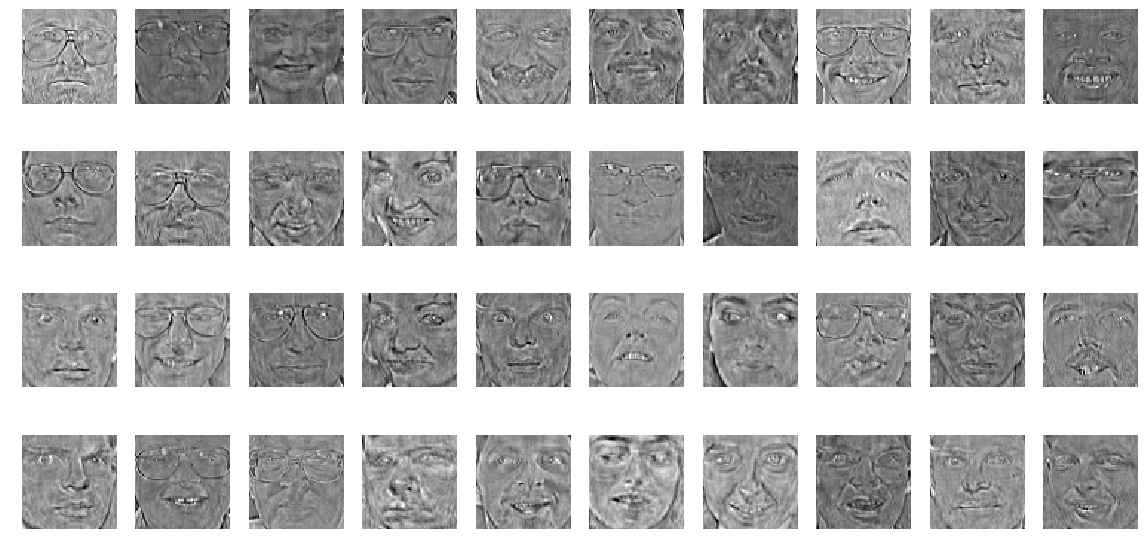

-5.029142e-09 1.0000033


In [9]:
# ZCA whiten the data (per example)
zca_white_layer = zca_whiten_layer()
train_data_zca = zca_white_layer.feedforward(train_data.reshape(400,-1).T).numpy().T
train_data_zca = train_data_zca.reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(train_data_zca[i-1],cmap='gray')
plt.show()
print(train_data_zca.mean(),train_data_zca.std())

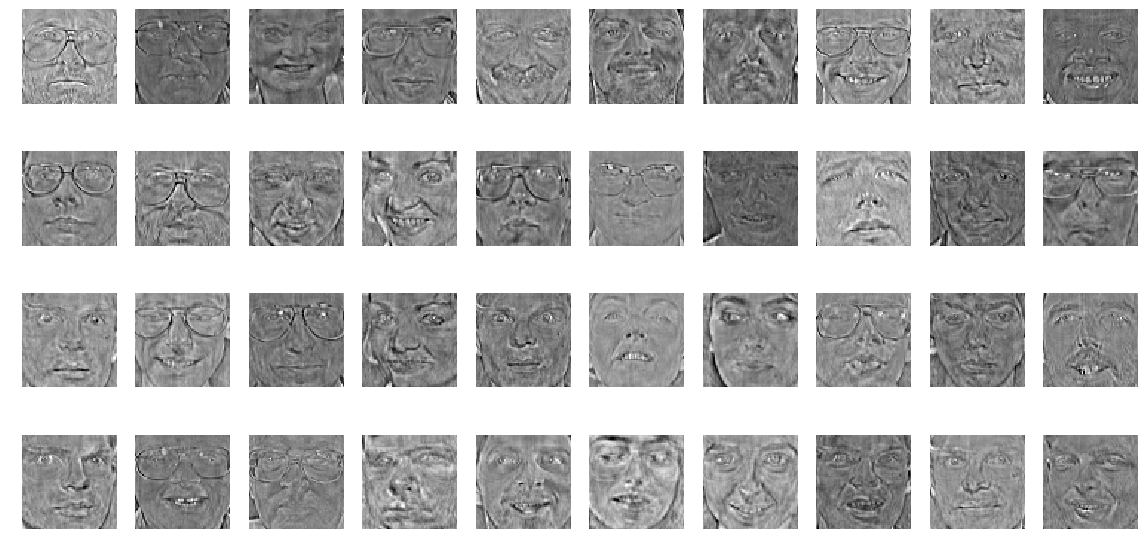

In [10]:
# Check ZCA whiten the data (per dimension)
# code from: https://gist.github.com/dmaniry/5170087
def fit(X):
    mean_data = np.mean(X, axis=0)
    X -= mean_data
    sigma = np.dot(X.T,X) / X.shape[1]
    from scipy import linalg as LA
    U, S, V = LA.svd(sigma)
    tmp = np.dot(U, np.diag(1/np.sqrt(S)))
    components_ = np.dot(tmp, U.T)
    return X.dot(components_)
zca_check_one = fit(train_data.reshape(400,-1)).reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_check_one[i-1],cmap='gray')
plt.show()

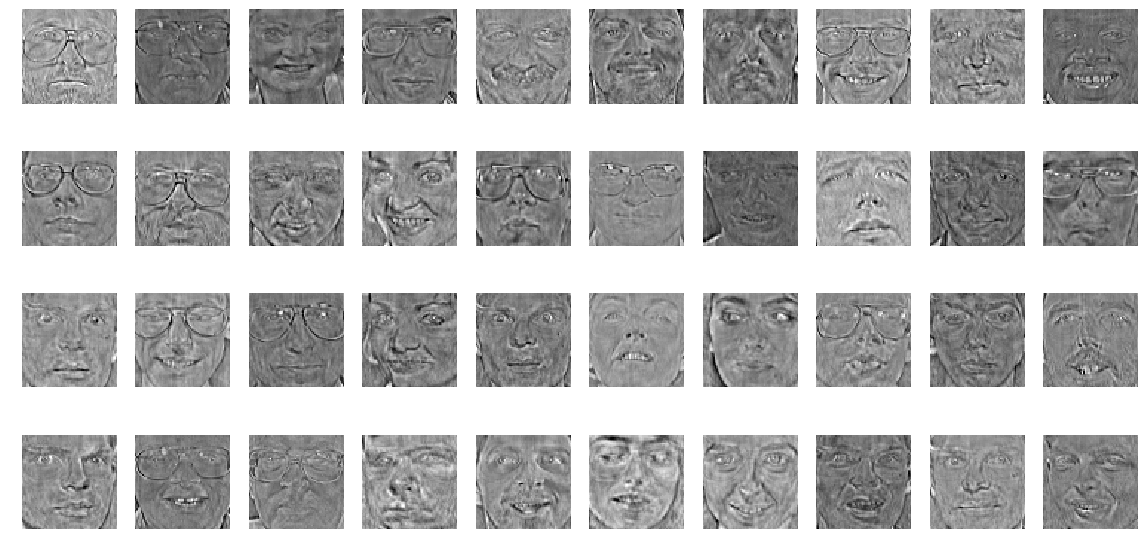

In [11]:
# Check ZCA whiten the data (per example) 
zca_check_two = fit(train_data.reshape(400,-1).T).T.reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_check_two[i-1],cmap='gray')
plt.show()

In [12]:
# Create the Orthonormal ICA Layer
class Orthonormal_ICA_Layer():
    
    def __init__(self,inc,outc):
        try:
            self.w = tf.Variable(tf.random_uniform(shape=[outc,inc],dtype=tf.float64))
        except:
            self.w = tf.contrib.eager.Variable(tf.random_uniform(shape=[outc,inc],dtype=tf.float64)) 
            
    def getw(self): return self.w
    def feedforward(self,input,weight):
        self.input = input
        self.layer = tf.matmul(weight,input)
        return self.layer
    
    def backprop(self,grad,old_weight):
        grad_w  = old_weight - learning_rate * tf.matmul(grad,tf.transpose(self.input))
        # W = (W*W.T) ^ (-1/2) * W 
        grad_w_I = tf.matmul(tf.pow(tf.matmul(grad_w,tf.transpose(grad_w)),-0.5),grad_w)
        grad_pass = tf.matmul(tf.transpose(self.w),grad)
        return grad_pass,grad_w_I
    

In [56]:
# hyper parameter and class 
num_epoch = 2
learning_rate = 0.5
print_size = 3
t = 0.02
lastCost = 1e40

# classes
num_of_basis_vector = 100
oica = Orthonormal_ICA_Layer(400,num_of_basis_vector)

# first weight
weightMatrix = oica.getw()
ica_layer = oica.feedforward(train_data_zca.reshape(400,-1).astype(np.float64),weightMatrix)
cost = tf.sqrt(tf.pow(ica_layer,2) + 1e-10)
_,grad = oica.backprop(ica_layer/(ica_layer.shape[0].value * cost),weightMatrix)

In [57]:
# start the training for num_epoch train_data_zca or train_data
for iter in range(num_epoch):
    
    newCost = float("inf")
    linearDelta = (grad.numpy() ** 2).sum()
    
    while 1:
        considerWeightMatrix = weightMatrix - learning_rate * grad
        considerWeightMatrix = tf.matmul(
            tf.pow(tf.matmul(considerWeightMatrix,tf.transpose(considerWeightMatrix)),-0.5)
            ,considerWeightMatrix)
        
        new_ica_layer = oica.feedforward(train_data_zca.reshape(400,-1).astype(np.float64),considerWeightMatrix)
        new_cost = tf.sqrt(tf.pow(new_ica_layer,2) + 1e-10)
        _,new_grad = oica.backprop(new_ica_layer/(new_ica_layer.shape[0].value * new_cost),considerWeightMatrix)
        
        print('Current new cost mean: ',new_cost.numpy().mean(),' last cost mean :',lastCost)
        print((lastCost - learning_rate * t * linearDelta).mean())
        # The New cost always have to be smaller - minimize        
        if new_cost.numpy().mean() > (lastCost - learning_rate * t * linearDelta).mean():
            t = -100
        else:
            break

    lastCost = new_cost.numpy().mean()
    weightMatrix = considerWeightMatrix
    t = 1.1 * t 
    
    cost = new_cost
    grad = new_grad
    print('\n------------------',iter,'------\n')

Current new cost mean:  90.13526096091701  last cost mean : 1e+40
1e+40

------------------ 0 ------

Current new cost mean:  91.56806732595132  last cost mean : 90.13526096091701
-10910.942619797761
Current new cost mean:  91.56806732595132  last cost mean : 90.13526096091701
50004989.593254946

------------------ 1 ------



In [ ]:
# Basic Details about the trained weights
# learned_basis = oica.feedforward(train_data_zca.reshape(400,-1).astype(np.float64)).numpy()
# learned_basis = start_w.numpy().dot(train_data_zca.reshape(400,-1).astype(np.float64))
# learned_basis = start_w.numpy()
# print('---- Learned Weight Info -----')
# print(learned_basis.shape)
# print(learned_basis.min(),learned_basis.max())
# print(learned_basis.mean(),learned_basis.std())

In [ ]:
import seaborn as sns
sns.heatmap(np.cov(start_w))
plt.show()
sns.heatmap(np.cov(end_w))
plt.show()


# def display_network(A,current_iter=None):
#     opt_normalize = True
#     opt_graycolor = True
#     # Rescale
#     A = A - np.average(A)
#     # Compute rows & cols
#     (row, col) = A.shape
#     sz = int(np.ceil(np.sqrt(row)))
#     buf = 1
#     n = int(np.ceil(np.sqrt(col)))
#     m = int(np.ceil(col / n))
#     image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
#     k = 0
#     for i in range(int(m)):
#         for j in range(int(n)):
#             if k >= col:
#                 continue
#             clim = np.max(np.abs(A[:, k]))
#             if opt_normalize:
#                 image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
#                     A[:, k].reshape(sz, sz) / clim
#             else:
#                 image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
#                     A[:, k].reshape(sz, sz) / np.max(np.abs(A))
#             k += 1
#     plt.axis('off')
#     plt.tight_layout()
#     plt.imshow(image,cmap='gray')
#     plt.show()
# display_network(learned_basis.T)


# sys.exit()
# learned_w_shape = learned_w.reshape(learned_w.shape[0],64,64)
# print(learned_w_shape.shape)
# fig=plt.figure(figsize=(40, 40))
# columns = 10; rows = 1
# for i in range(1, columns*rows +1):
#     fig.add_subplot(rows, columns, i)
#     plt.axis('off')
#     plt.imshow(learned_w_shape[i-1])
# plt.show()

In [320]:
! open ../../.

In [ ]:
! git add .
! git commit -m "From Mac"
! git push